# Support Vector Machine scores LB 0.925
In our previous kernel [here][1], we built 512 **linear** models using logistic regression in conjuction with the **magic feature** and scored LB 0.808. In this kernel we will build 512 **nonlinear** models using support vector machine with polynomial degree=4 kernel and score LB 0.926. Previously we performed feature selection with Lasso, aka LR's L1-penalty. Now we will perform feature selection with sklearn's VarianceThreshold selector (which will select more or less the same features). 

The success of this kernel demonstrates the nature of "Instant Gratification" competition data. It appears that the data is actually 512 datasets combined together. Each dataset has rougly 512 observations. Thus the total training data has `262144 = 512 * 512` observations. Each partial dataset is identified by a unique `wheezy-copper-turtle-magic` value. This kernel shows that each dataset's target is a nonlinear function of approximately 40 important features (and each dataset uses a different 40 important features).  
  
The next thing to investigate is whether there are interactions between the partial datasets that can improve prediction. If that is the case then instead of building 512 separate models, we need to build a single model that allows interactions. (Possibly NN with interesting architecture). 

Also each model (in this kernel) only uses about 40 features. Within each partial dataset, are the other 215 features really useless, or can we use them to improve prediction?

# Load Data

[1]: https://www.kaggle.com/cdeotte/logistic-regression-0-800

In [1]:
import numpy as np, pandas as pd, os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

# Build 512 Support Vector Models
Using cross validation, we determined that SVC's polynomial kernel with degree=4 achieves the best CV.

In [2]:
# LOAD LIBRARIES
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [3]:
# INITIALIZE VARIABLES
oof = np.zeros(len(train))
preds = np.zeros(len(test))
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

# BUILD 512 SEPARATE NON-LINEAR MODELS
for i in range(512):
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD (Using splits=25 scores 0.002 better but is slower)
    skf = StratifiedKFold(n_splits=11, random_state=42)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL WITH SUPPORT VECTOR MACHINE
        clf = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
    #if i%10==0: print(i)
        
# PRINT VALIDATION CV AUC
auc = roc_auc_score(train['target'],oof)
print('CV score =',round(auc,5))

CV score = 0.9262


# Submit Predictions

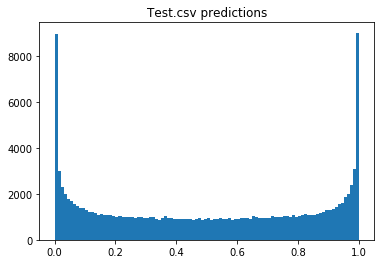

In [4]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Test.csv predictions')
plt.show()

# Conclusion
In conclusion, the success of using 512 separate models suggests that the 262144 rows of "Instant Gratification" dataset may actually be 512 partial datasets that were combined. Is this competition actually 512 models (competitions) in one? The appendix below investigates this further.

Three suggestions to improve this kernel's accuracy are (1) identify and model interactions between partial datasets (2) extract information from the approx 215 variables that are not used in each model (3) build better partial models than SVC polynomial degree=4 via NN or LGBM.

# Appendix
## Variables are not Gaussian
Each variable appears to be a nice bell shaped curve. However the curves are too tall and narrow. This is seen below by comparing the distribution of some variables with a Gaussian of the same mean and standard deviation. One can also verify that the variables are not Gaussian by making normality plots (pictured below).

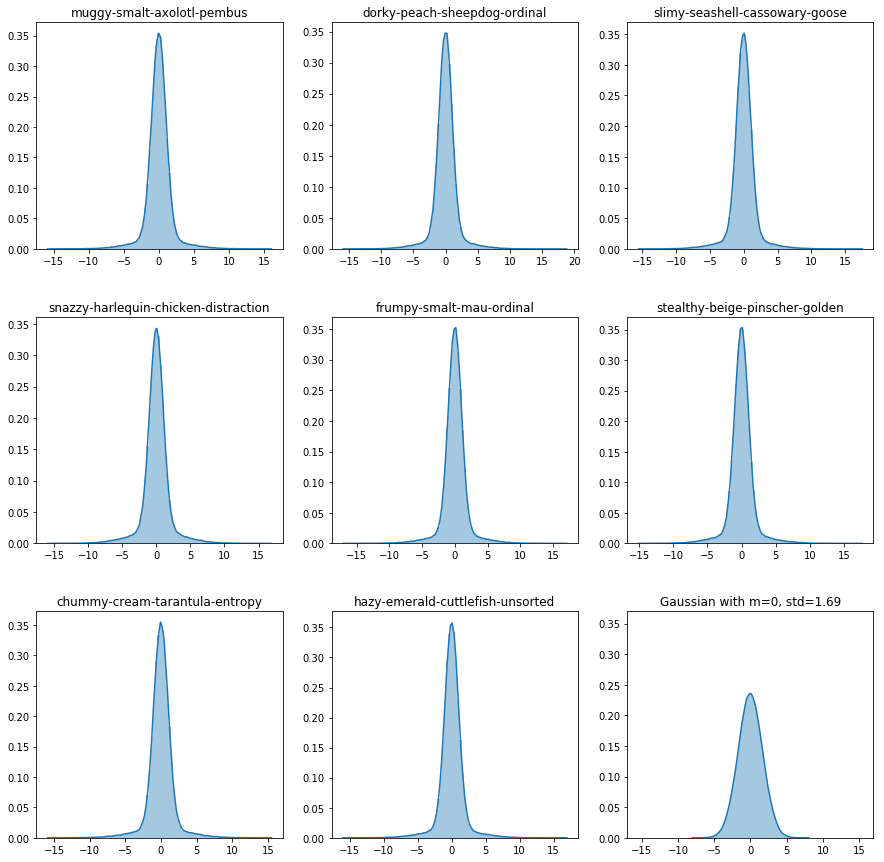

In [5]:
# LOAD LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# PLOT FIRST 8 VARIABLES
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3,i+1)
    #plt.hist(train.iloc[:,i+1],bins=100)
    sns.distplot(train.iloc[:,i+1],bins=100)
    plt.title( train.columns[i+1] )
    plt.xlabel('')
    
# PLOT GAUSSIAN FOR COMPARISON
plt.subplot(3,3,9)
std = round(np.std(train.iloc[:,8]),2)
data = np.random.normal(0,std,len(train))
sns.distplot(data,bins=100)
plt.xlim((-17,17))
plt.ylim((0,0.37))
plt.title("Gaussian with m=0, std="+str(std))

plt.subplots_adjust(hspace=0.3)
plt.show()

## Normality Plots
Normality plots indicate that the variables are not Gaussian. If they were Gaussian, then we would see straight lines below. Instead we see piecewise straight lines indicating that we may have Gaussian mixture models. (Each variable is the sum of multiple Gaussians).

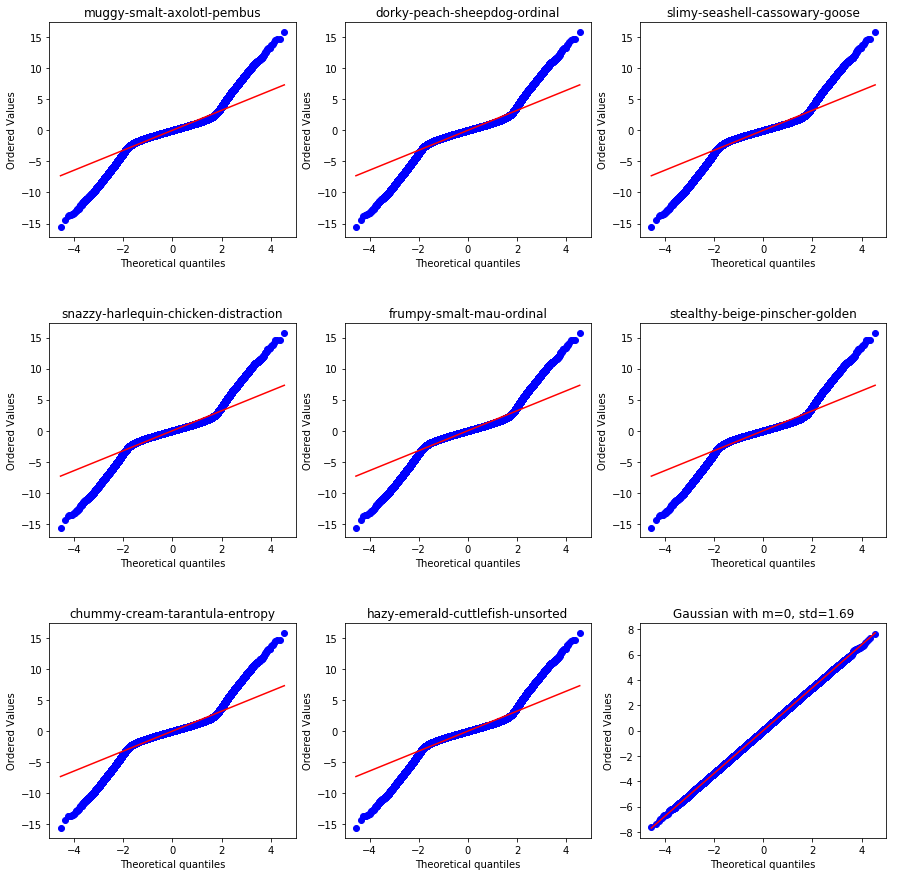

In [6]:
# NORMALITY PLOTS FOR FIRST 8 VARIABLES
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3,i+1)
    stats.probplot(train.iloc[:,1], plot=plt)
    plt.title( train.columns[i+1] )
    
# NORMALITY PLOT FOR GAUSSIAN
plt.subplot(3,3,9)
stats.probplot(data, plot=plt)   
plt.title("Gaussian with m=0, std="+str(std))

plt.subplots_adjust(hspace=0.4)
plt.show()

## Variables within partial datasets are Gaussian
If we only look at the partial datasets where `wheezy-copper-turtle-magic = k` for `0 <= k <= 511`, then the variables are Gaussian. This can be seen by the plots below. This suggests how the full dataset was made. Perhaps Kaggle made 512 different datasets and then combined them for this competition.

In [7]:
train0 = train[ train['wheezy-copper-turtle-magic']==0 ]

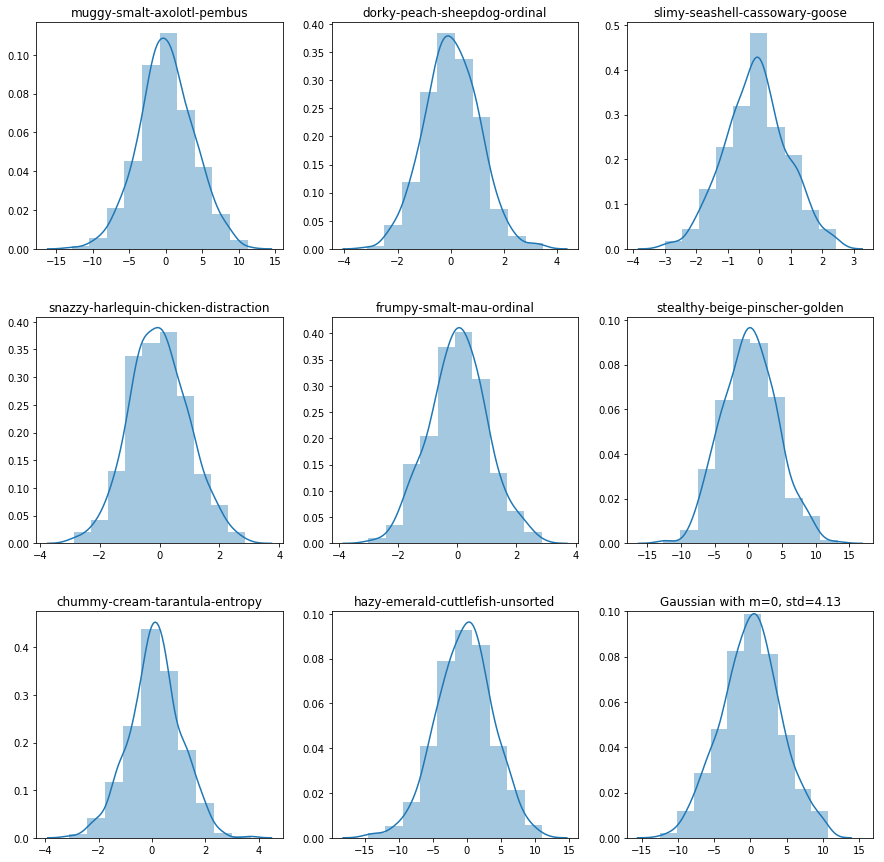

In [8]:
# PLOT FIRST 8 VARIABLES
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3,i+1)
    #plt.hist(train0.iloc[:,i+1],bins=10)
    sns.distplot(train0.iloc[:,i+1],bins=10)
    plt.title( train.columns[i+1] )
    plt.xlabel('')
    
# PLOT GAUSSIAN FOR COMPARISON
plt.subplot(3,3,9)
std0 = round(np.std(train0.iloc[:,8]),2)
data0 = np.random.normal(0,std0,2*len(train0))
sns.distplot(data0,bins=10)
plt.xlim((-17,17))
plt.ylim((0,0.1))
plt.title("Gaussian with m=0, std="+str(std0))
    
plt.subplots_adjust(hspace=0.3)
plt.show()

## Partial dataset normality plots

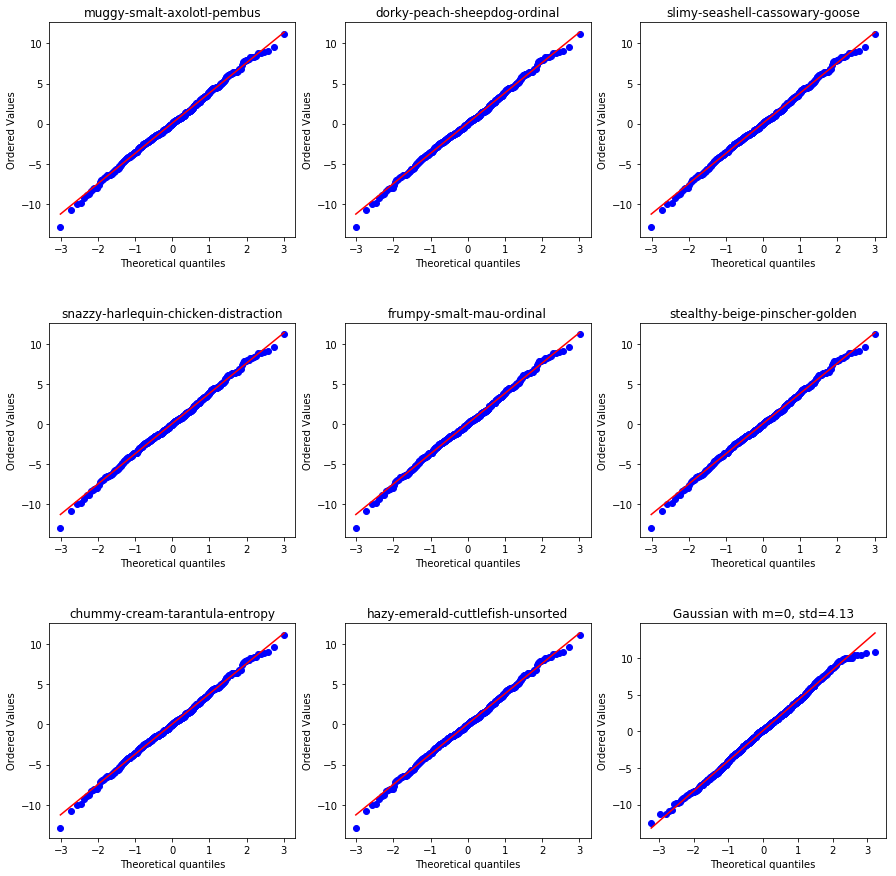

In [9]:
# NORMALITY PLOTS FOR FIRST 8 VARIABLES
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3,i+1)
    stats.probplot(train0.iloc[:,1], plot=plt)
    plt.title( train.columns[i+1] )
    
# NORMALITY PLOT FOR GAUSSIAN
plt.subplot(3,3,9)
stats.probplot(data0, plot=plt)   
plt.title("Gaussian with m=0, std="+str(std0))

plt.subplots_adjust(hspace=0.4)
plt.show()